# improting the libraries 

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import auc

import tensorflow as tf
import keras

from sklearn.preprocessing import StandardScaler

from keras.layers import Dropout
from keras import regularizers
from keras.callbacks import ModelCheckpoint


import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , roc_curve


/home/brian/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-10-01 20:58:54.327654: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-01 20:58:54.882494: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-01 20:58:54.886705: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-01 20:58:58.027278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
 from sklearn.decomposition import PCA

# funtions 

In [3]:
def neural_net(X_train_scaled , y_train , PLOT = False , num_epochs = 80 , input_shape =12 , train = True):
    # Build the neural network
    model = keras.Sequential([
        keras.layers.Dense(256, activation='relu', input_shape=(input_shape,), kernel_regularizer=regularizers.l2(0.01)),
        keras.layers.Dropout(0.4),  # Dropout layer with a 50% dropout rate
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.4),  # Dropout layer with a 50% dropout rate
        keras.layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(optimizer=keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(f'best_model_{num_epochs}.h5', monitor='val_loss', save_best_only=True)

    # Training
    if train :
        history = model.fit(X_train_scaled, y_train, epochs=num_epochs, batch_size=32, validation_split=0.2 ,  callbacks=[checkpoint])
    else:
        
        return print((model.summary()))
    if PLOT:
        training_loss = history.history['loss']
        training_accuracy = history.history['accuracy']
        validation_loss = history.history['val_loss']
        validation_accuracy = history.history['val_accuracy']

        # Plot the training and validation loss
        plt.plot(training_loss, label='Training Loss')
        plt.plot(validation_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Plot the training and validation accuracy
        plt.plot(training_accuracy, label='Training Accuracy')
        plt.plot(validation_accuracy, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

   
    return model
    

def pca_trans(X_train , X_test , n_comp = 12):
   
    shape_1 = X_train.shape
    pca = PCA(n_components=n_comp)
    pca = pca.fit(X_train)

    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    shape_2 = X_train_pca.shape
    print (f"INPUT DATA SHAPE WAS {shape_1}  final shape = {shape_2}")
    return X_train_pca , X_test_pca
def Scaler(new_data , ratio = 9000):
    train_data = new_data[:ratio]
    test_data = new_data[ratio:]
    train_data_val = train_data.pop('Exited')
    test_data_val = test_data.pop("Exited")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_data.to_numpy())
    Y_train = train_data_val.to_numpy()
    X_test_scaled = scaler.fit_transform(test_data.to_numpy())
    Y_test = test_data_val.to_numpy()
    return X_train_scaled , Y_train , X_test_scaled , Y_test


def save( X_test_pca ,Y_test  ):
# Reshape Y_test to have shape (1000, 1)
    Y_test = Y_test.reshape(-1, 1)

    # Create a Pandas DataFrame
    df = pd.DataFrame(np.hstack((X_test_pca, Y_test)), columns=['Feature_{}'.format(i) for i in range(X_test_pca.shape[1])] + ['Y Value'])

    # Save the DataFrame to a CSV file
    df.to_csv('test_data.csv', index=False)


def compute_metrics(y_pred ,Y_test , thresh ):
    y_pred_binary = y_pred >= thresh
    fpr, tpr, thresholds = roc_curve(Y_test, y_pred)

    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
    ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
    print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

    auc_value = auc(fpr, tpr)
    print("Area under curve, AUC = ", auc_value)


    cm = confusion_matrix(Y_test, y_pred_binary)
    print (cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

   
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'y--')
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()


    plt.show()



In [4]:
path = input ("Path to the data: ")
data = pd.read_csv(path)

INPUT DATA SHAPE WAS (9000, 2947)  final shape = (9000, 12)
Epoch 1/80
225/225 [==============================] - 7s 15ms/step - loss: 1.0021 - accuracy: 0.7908 - val_loss: 0.6547 - val_accuracy: 0.7894
Epoch 2/80
225/225 [==============================] - 3s 12ms/step - loss: 0.5734 - accuracy: 0.7946 - val_loss: 0.5126 - val_accuracy: 0.7894
Epoch 3/80
225/225 [==============================] - 3s 12ms/step - loss: 0.5000 - accuracy: 0.7946 - val_loss: 0.4802 - val_accuracy: 0.7894
Epoch 4/80
225/225 [==============================] - 3s 12ms/step - loss: 0.4856 - accuracy: 0.7947 - val_loss: 0.4688 - val_accuracy: 0.7894
Epoch 5/80
225/225 [==============================] - 3s 12ms/step - loss: 0.4753 - accuracy: 0.7947 - val_loss: 0.4642 - val_accuracy: 0.7933
Epoch 6/80
225/225 [==============================] - 3s 14ms/step - loss: 0.4706 - accuracy: 0.7992 - val_loss: 0.4591 - val_accuracy: 0.7956
Epoch 7/80
225/225 [==============================] - 3s 13ms/step - loss: 0.4686 

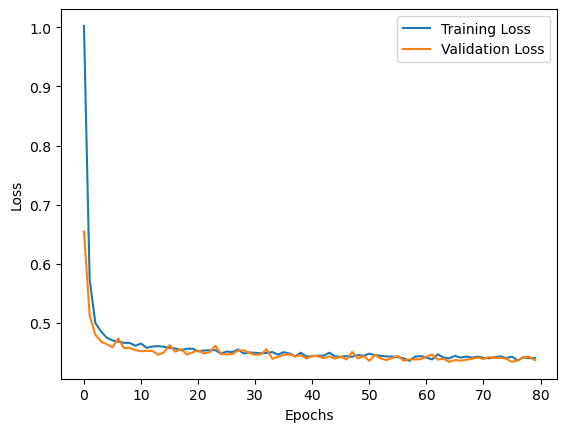

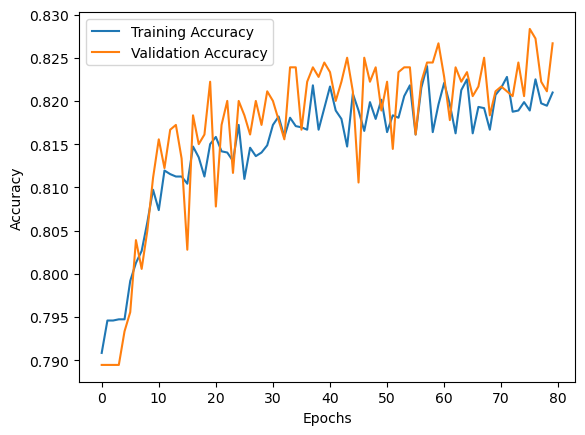

32/32 [==============================] - 0s 10ms/step - loss: 0.4182 - accuracy: 0.8370
Accuracy =  83.70000123977661 %


In [5]:
## encode the columns
full_data = data.copy()
full_data = pd.get_dummies(full_data)

## scla the data 
X_train , Y_train , X_test  , Y_test = Scaler(full_data)

## dimensionality reduction

X_train_pca , X_test_pca = pca_trans(X_train , X_test , n_comp = 12)


## create the model 
model = neural_net(X_train_pca , Y_train , train = True , PLOT = True, num_epochs = 80 , input_shape = 12)


## evaluating  the model 

_, acc = model.evaluate(X_test_pca, Y_test)
print("Accuracy = ", (acc * 100.0), "%")



In [6]:
## prediction 

y_pred = model.predict(X_test_pca)


32/32 [==============================] - 0s 4ms/step


In [7]:


fpr, tpr, thresholds = roc_curve(Y_test, y_pred)

i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 




Ideal threshold is:  154    0.191962
Name: thresholds, dtype: float32


In [ ]:
mythreshold=    float(input("Enter the thresh hold: "))
compute_metrics(y_pred , Y_test , mythreshold)